In [93]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [2]:

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

train = import_data(r"C:\Users\priya\OneDrive\Desktop\Priyanshu\SEMESTER 5\FDA\Project Assignments\dataset\train.csv")
test = import_data(r"C:\Users\priya\OneDrive\Desktop\Priyanshu\SEMESTER 5\FDA\Project Assignments\dataset\test.csv")


Memory usage of dataframe is 1039.79 MB
Memory usage after optimization is: 241.38 MB
Decreased by 76.8%
Memory usage of dataframe is 3837.77 MB
Memory usage after optimization is: 942.31 MB
Decreased by 75.4%


In [3]:
train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,...,37.375000,17.437500,19.203125,20.593750,-3.951172,14.507812,-4520.0,817.5,388.75,A
1,1,CA,0.015625,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,...,31.171875,19.406250,19.687500,21.359375,1.332031,17.750000,-4520.0,817.5,388.75,A
2,1,CA,0.019531,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,...,-12.015625,19.390625,23.171875,22.406250,1.538086,22.250000,-4520.0,817.5,388.75,A
3,1,CA,0.023438,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,...,18.578125,23.156250,22.640625,19.343750,2.544922,19.000000,-4520.0,817.5,388.75,A
4,1,CA,0.027344,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,...,6.554688,22.750000,22.671875,20.296875,1.699219,22.812500,-4520.0,817.5,388.75,A


In [4]:
test.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.906250,6.128906,0.994629,-28.203125,-47.687500,...,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-7324.0,643.0,595.00
1,1,1,LOFT,0.000000,1,45.875000,94.750000,23.296875,1.391602,2.060547,...,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-3336.0,826.5,136.25
2,2,1,LOFT,0.003906,0,33.125000,28.359375,-7.238281,-7.691406,-25.828125,...,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-7324.0,643.0,595.00
3,3,1,LOFT,0.003906,1,43.281250,95.875000,18.703125,-1.432617,-4.234375,...,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-3336.0,826.5,136.25
4,4,1,LOFT,0.007812,0,7.929688,3.460938,-10.859375,-26.359375,-25.890625,...,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-7324.0,643.0,595.00


In [6]:
print(list(enumerate(train.columns)))
print()
print(list(enumerate(test.columns)))

[(0, 'crew'), (1, 'experiment'), (2, 'time'), (3, 'seat'), (4, 'eeg_fp1'), (5, 'eeg_f7'), (6, 'eeg_f8'), (7, 'eeg_t4'), (8, 'eeg_t6'), (9, 'eeg_t5'), (10, 'eeg_t3'), (11, 'eeg_fp2'), (12, 'eeg_o1'), (13, 'eeg_p3'), (14, 'eeg_pz'), (15, 'eeg_f3'), (16, 'eeg_fz'), (17, 'eeg_f4'), (18, 'eeg_c4'), (19, 'eeg_p4'), (20, 'eeg_poz'), (21, 'eeg_c3'), (22, 'eeg_cz'), (23, 'eeg_o2'), (24, 'ecg'), (25, 'r'), (26, 'gsr'), (27, 'event')]

[(0, 'id'), (1, 'crew'), (2, 'experiment'), (3, 'time'), (4, 'seat'), (5, 'eeg_fp1'), (6, 'eeg_f7'), (7, 'eeg_f8'), (8, 'eeg_t4'), (9, 'eeg_t6'), (10, 'eeg_t5'), (11, 'eeg_t3'), (12, 'eeg_fp2'), (13, 'eeg_o1'), (14, 'eeg_p3'), (15, 'eeg_pz'), (16, 'eeg_f3'), (17, 'eeg_fz'), (18, 'eeg_f4'), (19, 'eeg_c4'), (20, 'eeg_p4'), (21, 'eeg_poz'), (22, 'eeg_c3'), (23, 'eeg_cz'), (24, 'eeg_o2'), (25, 'ecg'), (26, 'r'), (27, 'gsr')]


The sensors are:

eeg - Electroencephalogram - brain electrical activity sensors
ecg - Electrocardiogram - heart electrical activity sensor,
r - Respiration - chest movement sensor
gsr - Galvanic Skin Response - skin reponse sensor.
Our target feature is 'event'. There are 4 events in this test with the labels which we need to learn and predict:

A - baseline
B - SS - Startle/Surprise
C - CA - Channelized Attention
D - DA - Diverted Attention

In [8]:
print(train.shape)
print(test.shape)

(4867421, 28)
(17965143, 28)


In [9]:
print(train.crew.unique())
print(test.crew.unique())

[ 1  2  3  4  5  6  7  8 13]
[ 1  2  3  4  5  6  7  8 13]


In [16]:
train.isnull().sum()

crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

No null values in train data

In [17]:
test.isnull().sum()

id            0
crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
dtype: int64

No null values in test data

In [19]:
pd.crosstab(train.experiment,train.event)

event,A,B,C,D
experiment,,,,
CA,5690,0,1652686,0
DA,1423064,0,0,235329
SS,1420055,130597,0,0


A indicates Baseline(no event), B indicates Startle/Surprise, C indicates CA, and D indicates DA

In [20]:
pd.crosstab(train['experiment'], train['crew'])

crew,1,2,3,4,5,6,7,8,13
experiment,,,,,,,,,
CA,184299,184232,184232,184337,184252,184254,184238,184244,184288
DA,184207,184293,184274,184301,184292,184389,184235,184195,184207
SS,79146,184343,184289,184243,184271,184315,184296,181520,184229


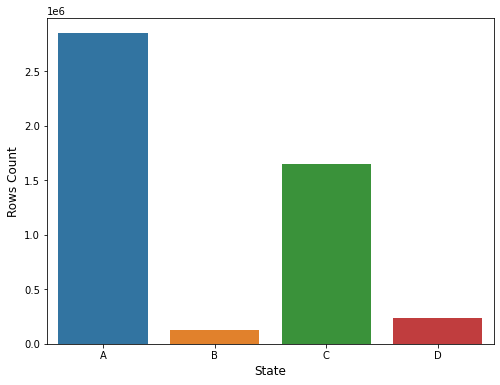

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(train.event)
plt.xlabel("State", fontsize=12)
plt.ylabel("Rows Count", fontsize=12)
plt.show()

In [22]:
train.time.describe()

count    4.867421e+06
mean              NaN
std               NaN
min      3.000259e-03
25%      8.806250e+01
50%      1.768750e+02
75%      2.682500e+02
max      3.602500e+02
Name: time, dtype: float64

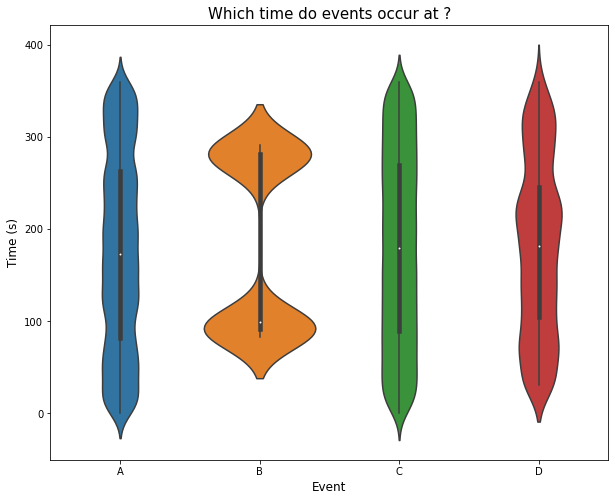

In [26]:
plt.figure(figsize=(10,8))
sns.violinplot(x='event', y='time', data=train.sample(50000))
plt.ylabel("Time (s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Which time do events occur at ?", fontsize=15)
plt.show()

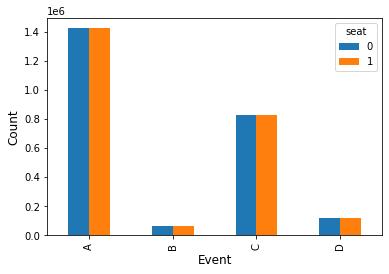

In [27]:
pd.crosstab(train.event,train.seat).plot(kind='bar')
plt.xlabel("Event", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

No. of each type of event is similar for both seats

# Data Wrangling

### Encoding Categorical Text Variables

There are two categorical variables in the train data (event,experiment)

In [28]:
train.experiment.value_counts()

DA    1658393
CA    1658376
SS    1550652
Name: experiment, dtype: int64

In [29]:
test.experiment.value_counts()

LOFT    17965143
Name: experiment, dtype: int64

In [30]:
test_id = test['id']
test.drop(['id'], axis=1, inplace=True)


dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
dic1 = {'CA':0,'DA':1,'SS':3,'LOFT':4}
train["event"] = train["event"].apply(lambda x: dic[x])
train["event"] = train["event"].astype('int8')
train['experiment'] = train['experiment'].apply(lambda x: dic1[x])
test['experiment'] = test['experiment'].apply(lambda x: dic1[x])

train['experiment'] = train['experiment'].astype('int8')
test['experiment'] = test['experiment'].astype('int8')

In [31]:
train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,0,0.011719,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,...,37.375000,17.437500,19.203125,20.593750,-3.951172,14.507812,-4520.0,817.5,388.75,0
1,1,0,0.015625,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,...,31.171875,19.406250,19.687500,21.359375,1.332031,17.750000,-4520.0,817.5,388.75,0
2,1,0,0.019531,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,...,-12.015625,19.390625,23.171875,22.406250,1.538086,22.250000,-4520.0,817.5,388.75,0
3,1,0,0.023438,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,...,18.578125,23.156250,22.640625,19.343750,2.544922,19.000000,-4520.0,817.5,388.75,0
4,1,0,0.027344,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,...,6.554688,22.750000,22.671875,20.296875,1.699219,22.812500,-4520.0,817.5,388.75,0


In [32]:
test.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,4,0.000000,0,17.906250,6.128906,0.994629,-28.203125,-47.687500,-187.125000,...,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-7324.0,643.0,595.00
1,1,4,0.000000,1,45.875000,94.750000,23.296875,1.391602,2.060547,-5.144531,...,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-3336.0,826.5,136.25
2,1,4,0.003906,0,33.125000,28.359375,-7.238281,-7.691406,-25.828125,-107.250000,...,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-7324.0,643.0,595.00
3,1,4,0.003906,1,43.281250,95.875000,18.703125,-1.432617,-4.234375,-8.023438,...,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-3336.0,826.5,136.25
4,1,4,0.007812,0,7.929688,3.460938,-10.859375,-26.359375,-25.890625,37.000000,...,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-7324.0,643.0,595.00


### Z Score to detect Outliers

In [34]:
from scipy import stats

In [35]:
z=np.abs(stats.zscore(train)) # calculating z score
z

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [36]:
threshold=3
np.where(z>threshold) # position where outliers are present

(array([], dtype=int64), array([], dtype=int64))

There are no outliers in the data

### Splitting independent and dependent variables

In [42]:
y=train.event
train.drop('event',axis=1,inplace=True)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.4, random_state=25)
print(f'Number of rows in X_train: {X_train.shape[0]}')
print(f'Number of rows in X_test: {X_test.shape[0]}')

Number of rows in X_train: 2920452
Number of rows in X_test: 1946969


In [49]:
X_train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
2300006,5,1,114.750000,0,-26.843750,-19.734375,-12.429688,-16.031250,-5.886719,-15.664062,...,-59.531250,-49.125000,-14.445312,-14.546875,-18.546875,-25.437500,-15.921875,-2296.0,648.5,1672.00
4776153,13,3,261.500000,0,-2.169922,-0.635742,4.269531,19.000000,3.074219,-18.843750,...,2.146484,3.695312,0.699707,-7.644531,-23.000000,-2.755859,-1.703125,-14296.0,675.5,491.75
4151479,8,3,13.843750,1,-7.269531,-8.265625,6.808594,8.914062,11.242188,10.898438,...,1.213867,1.989258,2.845703,3.910156,2.314453,-5.312500,3.648438,6324.0,803.0,1172.00
556272,2,0,29.203125,1,6.253906,11.015625,4.101562,3.585938,-7.296875,1.021484,...,2.613281,0.601562,-3.646484,-3.464844,-0.345947,-0.851562,-7.355469,6564.0,817.0,1750.00
3319939,7,0,289.000000,1,11.664062,3.197266,18.640625,17.031250,7.816406,3.667969,...,8.257812,13.328125,8.453125,4.855469,3.414062,4.140625,9.101562,17840.0,831.0,708.00


### Feature Importance

In [51]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(train,y)

ExtraTreesClassifier()

In [52]:
print(model.feature_importances_)

[0.01531078 0.65336739 0.07294627 0.00400903 0.00748646 0.00718524
 0.00773869 0.00464369 0.00420283 0.00408866 0.00507419 0.00788043
 0.00427289 0.00411466 0.0056306  0.00664355 0.00591453 0.00626319
 0.00441403 0.00442632 0.00486016 0.00462933 0.00539573 0.00437058
 0.04270581 0.04304584 0.05937912]


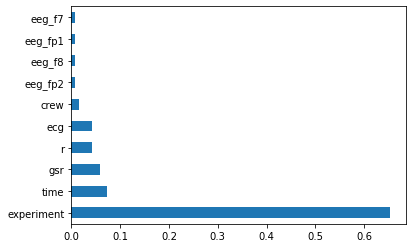

In [54]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [55]:
dfscores = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(train.columns)

In [56]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Column_Name','Score']  #naming the dataframe columns
featureScores

,Column_Name,Score
0,crew,0.015311
1,experiment,0.653367
2,time,0.072946
3,seat,0.004009
4,eeg_fp1,0.007486
5,eeg_f7,0.007185
6,eeg_f8,0.007739
7,eeg_t4,0.004644
8,eeg_t6,0.004203
9,eeg_t5,0.004089


In [57]:
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Column_Name     Score
1   experiment  0.653367
2         time  0.072946
26         gsr  0.059379
25           r  0.043046
24         ecg  0.042706
0         crew  0.015311
11     eeg_fp2  0.007880
6       eeg_f8  0.007739
4      eeg_fp1  0.007486
5       eeg_f7  0.007185


In [60]:
feature_names=['experiment','time','gsr','r','ecg','crew','eeg_fp2','eeg_f8','eeg_fp1','eeg_f7']

In [61]:
train_fs=train[feature_names]
train_fs.head()

,experiment,time,gsr,r,ecg,crew,eeg_fp2,eeg_f8,eeg_fp1,eeg_f7
0,0,0.011719,388.75,817.5,-4520.0,1,-6.695312,-9.523438,-5.285156,26.781250
1,0,0.015625,388.75,817.5,-4520.0,1,-6.476562,-9.320312,-2.427734,28.437500
2,0,0.019531,388.75,817.5,-4520.0,1,-0.088684,15.351562,10.671875,30.421875
3,0,0.023438,388.75,817.5,-4520.0,1,-0.256592,2.433594,11.453125,25.609375
4,0,0.027344,388.75,817.5,-4520.0,1,-1.953125,0.113586,7.285156,25.937500


# Model Building and Evaluation

### Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dt_grid=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid={'criterion':["gini", "entropy"]},cv=3)

In [82]:
dt_grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy']})

In [84]:
dt_grid.best_params_

{'criterion': 'entropy'}

In [74]:
dt=DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [75]:
print('Accuracy of Decision Tree with all features',dt.score(X_test,y_test))

Accuracy of Decision Tree with all features 0.9993733849896942


In [65]:
from sklearn import metrics
y_pred=dt.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.0017067554747918431
MSE: 0.004923036781787486
RMSE: 0.07016435549328082


Normalized confusion matrix
[[9.99471533e-01 7.19839388e-05 1.14120879e-05 4.45071427e-04]
 [1.72015061e-03 9.98279849e-01 0.00000000e+00 0.00000000e+00]
 [1.05858673e-05 0.00000000e+00 9.99989414e-01 0.00000000e+00]
 [5.62358084e-03 0.00000000e+00 0.00000000e+00 9.94376419e-01]]


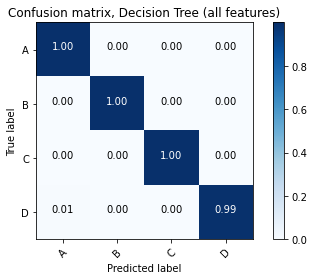

In [86]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=["A", "B", "C", "D"],
                      title='Confusion matrix, Decision Tree (all features)')

### Decision Tree (Using feature importance)

In [76]:
dt1=DecisionTreeClassifier(criterion='entropy')
dt1.fit(X_train[feature_names],y_train)

DecisionTreeClassifier()

In [79]:
print('Accuracy of Decision Tree with top 10 important features',dt.score(X_test,y_test))

Accuracy of Decision Tree with top 10 important features 0.9993733849896942


In [71]:
y_pred1=dt.predict(X_test[feature_names])
print('MAE:', metrics.mean_absolute_error(y_test, y_pred1))
print('MSE:', metrics.mean_squared_error(y_test, y_pred1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

MAE: 0.0012470665942806486
MSE: 0.0035819779359609733
RMSE: 0.05984962770110582


Normalized confusion matrix
[[9.99618134e-01 5.26711747e-05 1.40456466e-05 3.15149195e-04]
 [1.37612049e-03 9.98623880e-01 0.00000000e+00 0.00000000e+00]
 [1.05858673e-05 0.00000000e+00 9.99989414e-01 0.00000000e+00]
 [4.14871719e-03 0.00000000e+00 0.00000000e+00 9.95851283e-01]]


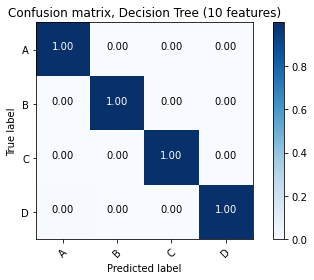

In [88]:
cnf_matrix1 = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cnf_matrix1, classes=["A", "B", "C", "D"],
                      title='Confusion matrix, Decision Tree (10 features)')

### Light GBM

In [89]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(n_estimators=100,learning_rate=0.05)

In [94]:
clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)
print("Accuracy of lgbm: ", accuracy_score(y_pred2, y_test))

Accuracy of lgbm:  0.9829098460222017


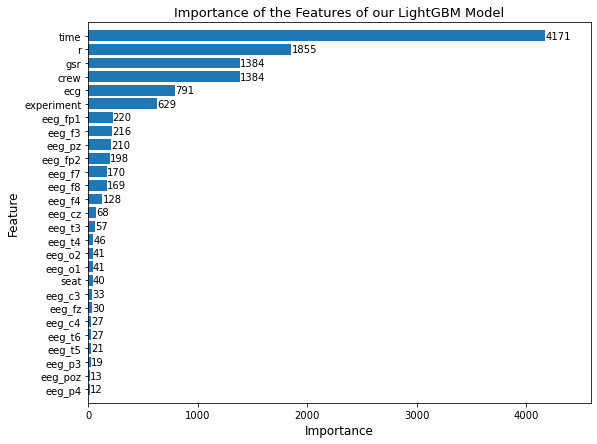

In [95]:
fig, ax = plt.subplots(figsize=(9,7))
lgb.plot_importance(clf, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=13)
plt.show()

In [96]:
pred = clf.predict_proba(test) # running model on test dataset
sub = pd.DataFrame(pred,columns=['A', 'B', 'C', 'D']) # submission dataset
sub['id'] = test_id
cols = sub.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub = sub[cols]
sub.to_csv(r"C:\Users\priya\OneDrive\Desktop\Priyanshu\SEMESTER 5\FDA\Project Assignments\lgbm.csv", index=False)

In [100]:
sub.head() # submission file

,id,A,B,C,D
0,0,0.999695,0.000058,0.000209,0.000037
1,1,0.999668,0.000077,0.000217,0.000039
2,2,0.999701,0.000053,0.000209,0.000037
3,3,0.999668,0.000077,0.000217,0.000039
4,4,0.999690,0.000063,0.000209,0.000037


In [102]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred2))
print('MSE:', metrics.mean_squared_error(y_test, y_pred2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

MAE: 0.04992015794807211
MSE: 0.14836445778027282
RMSE: 0.3851810714200178


Normalized confusion matrix
[[9.95485202e-01 6.24153421e-04 4.56483514e-05 3.84499576e-03]
 [1.06840466e-02 9.89315953e-01 0.00000000e+00 0.00000000e+00]
 [5.59538698e-05 0.00000000e+00 9.99944046e-01 0.00000000e+00]
 [2.92160941e-01 0.00000000e+00 0.00000000e+00 7.07839059e-01]]


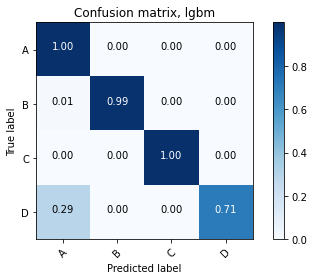

In [101]:
cnf_matrix2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(cnf_matrix2, classes=["A", "B", "C", "D"], title='Confusion matrix, lgbm')

### Saving Model

In [103]:
import joblib
joblib.dump(clf,r"C:\Users\priya\OneDrive\Desktop\Priyanshu\SEMESTER 5\FDA\Project Assignments\Reducing Commercial Aviation Fatalities\lgbm_model")

['C:\\Users\\priya\\OneDrive\\Desktop\\Priyanshu\\SEMESTER 5\\FDA\\Project Assignments\\Reducing Commercial Aviation Fatalities\\lgbm_model']